<p><b>Q1</b></p>

In [1]:
import pandas as pd
import numpy as np

In [2]:
loanStats = pd.read_csv('LoanStats_2016Q4.csv', skiprows = 1)
rejectStats = pd.read_csv('RejectStats_2016Q4.csv', skiprows = 1)

C:\Users\ghxye\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
loanStats = loanStats.drop(loanStats.index[-2:])
loanStats = loanStats.drop(['id', 'member_id'], axis = 1)

print(loanStats.shape)
print(loanStats.columns)
print(rejectStats.shape)
print(rejectStats.columns)

(103546, 142)
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=142)
(1404490, 9)
Index(['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score',
       'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length',
       'Policy Code'],
      dtype='object')


In [4]:
approved = pd.DataFrame()
rejected = pd.DataFrame()

approved['amount'] = loanStats['loan_amnt']
rejected['amount'] = rejectStats['Amount Requested']

In [5]:
stop_words = ['and', 'expenses', 'financing', 'loan', 'refinancing']
approved['reason'] = loanStats['title'].apply(lambda x: 'other' if type(x) != str else '_'.join([i for i in x.lower().split() if i not in stop_words]))
rejected['reason'] = rejectStats['Loan Title'].apply(lambda x: 'other' if type(x) != str else '_'.join([i for i in x.lower().split() if i not in stop_words]))
convert = {'house': 'home_buying', 'moving': 'moving_relocation', 'renewable_energy': 'green', 'small_business': 'business'}
rejected['reason'] = rejected['reason'].apply(lambda x: convert[x] if x in convert else x)

In [6]:
approved['debt_to_income'] = loanStats['dti'].apply(lambda x: max(0.0, min(x / 100, 1.0)) if x == x else 1.0)
rejected['debt_to_income'] = rejectStats['Debt-To-Income Ratio'].apply(lambda x: max(0.0, min(float(x[:-1]) / 100, 1.0)))

In [7]:
approved['zip3'] = loanStats['zip_code'].apply(lambda x: x[:3] if type(x) == str else 'N/A')
rejected['zip3'] = rejectStats['Zip Code'].apply(lambda x: x[:3] if type(x) == str else 'N/A')
approved['state'] = loanStats['addr_state']
rejected['state'] = rejectStats['State']

In [8]:
approved['employ_length'] = loanStats['emp_length'].apply(lambda x: 0 if type(x) != str or x[:3] == '< 1' else int(x[:2]))
rejected['employ_length'] = rejectStats['Employment Length'].apply(lambda x: 0 if type(x) != str or x[:3] == '< 1' else int(x[:2]))

In [9]:
approved = pd.concat([approved, pd.get_dummies(approved['reason'], prefix = 'reason', prefix_sep = '_=_').drop('reason_=_other', axis = 1)], axis = 1).drop('reason', axis = 1)
rejected = pd.concat([rejected, pd.get_dummies(rejected['reason'], prefix = 'reason', prefix_sep = '_=_').drop('reason_=_other', axis = 1)], axis = 1).drop('reason', axis = 1)

In [10]:
approved['approved'] = 1
rejected['approved'] = 0

data_pos = approved.drop(['zip3', 'state'], axis = 1).values
data_neg = rejected.drop(['zip3', 'state'], axis = 1).values

print(data_pos.shape)
print(data_neg.shape)

(103546, 15)
(1404490, 15)


In [11]:
data = np.vstack((data_pos, data_neg))
data

array([[4.500e+03, 2.993e-01, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [9.300e+03, 1.612e-01, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.150e+04, 2.018e-01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.200e+03, 1.026e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.500e+04, 1.771e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.500e+04, 1.058e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [12]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(data[:,:-1], data[:,-1].astype(int), test_size = 0.5, random_state = 2020)

In [13]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

<p><b>Model: gradient boosting----------</b></p>
<p> Histogram based gradient boosting classifier</p>

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics

In [15]:
from sklearn.metrics import fbeta_score, make_scorer

fhalf_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 0.5)
grid = model_selection.GridSearchCV(HistGradientBoostingClassifier(),
                    param_grid = {'l2_regularization': [0.01 * i for i in range(1,5)]}, scoring = fhalf_scorer, cv = 10)

In [16]:
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
             param_grid={'l2_regularization': [0.01, 0.02, 0.03, 0.04]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [17]:
grid.best_params_

{'l2_regularization': 0.02}

In [18]:
hgbc_cla = HistGradientBoostingClassifier(l2_regularization = 0.02)

hgbc_cla.fit(x_train, y_train)

hgbc_y_pred = hgbc_cla.predict(x_test)

In [19]:
hgbc_cfm = metrics.confusion_matrix(y_test, hgbc_y_pred)
hgbc_cfm

array([[687141,  14954],
       [ 13448,  38475]], dtype=int64)

In [20]:
hgbc_tn, hgbc_fp, hgbc_fn, hgbc_tp = hgbc_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_hgbc = hgbc_tp / (hgbc_tp + hgbc_fp)
recall_hgbc = hgbc_tp/ (hgbc_tp + hgbc_fn)

print('True positive: ' + str(hgbc_tp))
print('False positive: ' + str(hgbc_fp))
print('True negative: ' + str(hgbc_tn))
print('False negative: ' + str(hgbc_fn))

print('precision: ' + str(precision_hgbc))
print('Recall: ' + str(recall_hgbc))

True positive: 38475
False positive: 14954
True negative: 687141
False negative: 13448
precision: 0.720114544535739
Recall: 0.7410010977794041


<p><u>Findings:</u></p>
<p>Precision is less than recall; focus on precision. Hence f-beta will be 0.5. </p>

In [21]:
fhalf_hgbc = metrics.fbeta_score(y_test, hgbc_y_pred, beta = 0.5)
print('The f0.5 xgboost score is: ' + str(fhalf_hgbc))

The f0.5 xgboost score is: 0.7241971246691938


In [22]:
yProb_hgbc = hgbc_cla.predict_proba(x_test)
yProb_hgbc
# fpr = false +ve rates; tpr = true +ve rates
fpr_hgbc, tpr_hgbc, _ = metrics.roc_curve(y_test, yProb_hgbc[:,1])
auc_roc_hgbc = metrics.auc(fpr_hgbc, tpr_hgbc)

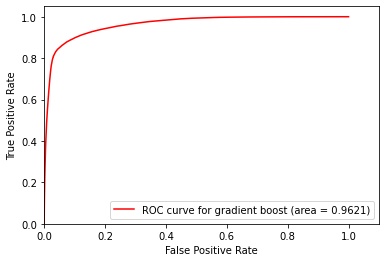

In [23]:
import matplotlib.pyplot as plt

plt.plot(fpr_hgbc, tpr_hgbc, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_hgbc)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [24]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_hgbc)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.9621156155275242


<p><b>Model: Bagging----------</b></p>
<p> Bagging classifier</p>

In [25]:
from sklearn.ensemble import BaggingClassifier

In [35]:
fhalf_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 0.5)
grid1 = model_selection.GridSearchCV(BaggingClassifier(n_estimators = 100, n_jobs = -1),
                    param_grid = {'max_samples': [1, 10, 100, 1000]}, scoring = fhalf_scorer, cv = 10)

In [36]:
grid1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=BaggingClassifier(n_estimators=100, n_jobs=-1),
             param_grid={'max_samples': [1, 10, 100, 1000]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [37]:
grid1.best_params_

{'max_samples': 1000}

In [38]:
bag_cla = BaggingClassifier(max_samples = 1000, n_estimators = 100)

bag_cla.fit(x_train, y_train)

bag_y_pred = bag_cla.predict(x_test)

In [39]:
bag_cfm = metrics.confusion_matrix(y_test, bag_y_pred)
bag_cfm

array([[685589,  16506],
       [ 13025,  38898]], dtype=int64)

In [40]:
bag_tn, bag_fp, bag_fn, bag_tp = bag_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_bag = bag_tp / (bag_tp + bag_fp)
recall_bag = bag_tp/ (bag_tp + bag_fn)

print('True positive: ' + str(bag_tp))
print('False positive: ' + str(bag_fp))
print('True negative: ' + str(bag_tn))
print('False negative: ' + str(bag_fn))

print('precision: ' + str(precision_bag))
print('Recall: ' + str(recall_bag))

True positive: 38898
False positive: 16506
True negative: 685589
False negative: 13025
precision: 0.7020792722547109
Recall: 0.7491477765152245


<p><u>Findings:</u></p>
<p>Precision is less precise; focus on precision. Hence f-beta will be 0.5. </p>

In [41]:
fhalf_bag = metrics.fbeta_score(y_test, bag_y_pred, beta = 0.5)
print('The f2 xgboost score is: ' + str(fhalf_bag))

The f2 xgboost score is: 0.7110137859683628


In [42]:
yProb_bag = bag_cla.predict_proba(x_test)
yProb_bag
# fpr = false +ve rates; tpr = true +ve rates
fpr_bag, tpr_bag, _ = metrics.roc_curve(y_test, yProb_bag[:,1])
auc_roc_bag = metrics.auc(fpr_bag, tpr_bag)

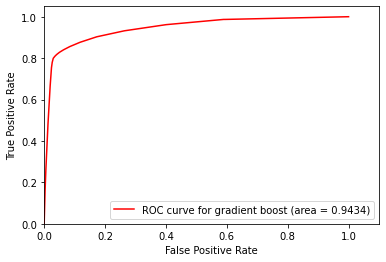

In [43]:
plt.plot(fpr_bag, tpr_bag, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_bag)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [44]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_bag)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.9433906282659188


### Model stacking

In [45]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [46]:
estimators = [('hgbc', HistGradientBoostingClassifier()),
              ('bc', BaggingClassifier(n_estimators = 100))]

stackModel = StackingClassifier(estimators = estimators, 
                                final_estimator = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_depth = 3))

In [47]:
stackModel.get_params()

{'cv': None,
 'estimators': [('hgbc', HistGradientBoostingClassifier()),
  ('bc', BaggingClassifier(n_estimators=100))],
 'final_estimator__bootstrap': True,
 'final_estimator__ccp_alpha': 0.0,
 'final_estimator__class_weight': None,
 'final_estimator__criterion': 'gini',
 'final_estimator__max_depth': 3,
 'final_estimator__max_features': 'auto',
 'final_estimator__max_leaf_nodes': None,
 'final_estimator__max_samples': None,
 'final_estimator__min_impurity_decrease': 0.0,
 'final_estimator__min_impurity_split': None,
 'final_estimator__min_samples_leaf': 1,
 'final_estimator__min_samples_split': 2,
 'final_estimator__min_weight_fraction_leaf': 0.0,
 'final_estimator__n_estimators': 100,
 'final_estimator__n_jobs': -1,
 'final_estimator__oob_score': False,
 'final_estimator__random_state': None,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': RandomForestClassifier(max_depth=3, n_jobs=-1),
 'n_jobs': None,
 'passthrough': False,
 'stack_method

In [48]:
params = {'hgbc__l2_regularization':[0.01 * i for i in range(1,5)],
          'bc__max_samples':[1, 10, 100, 1000],'bc__n_jobs':[-1],
         'final_estimator__ccp_alpha':[0.01 * i for i in range(1,5)]}

gridModel = model_selection.GridSearchCV(estimator = stackModel, param_grid = params, cv = 3, scoring = fhalf_scorer)

In [49]:
gridModel.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('hgbc',
                                                       HistGradientBoostingClassifier()),
                                                      ('bc',
                                                       BaggingClassifier(n_estimators=100))],
                                          final_estimator=RandomForestClassifier(max_depth=3,
                                                                                 n_jobs=-1)),
             param_grid={'bc__max_samples': [1, 10, 100, 1000],
                         'bc__n_jobs': [-1],
                         'final_estimator__ccp_alpha': [0.01, 0.02, 0.03, 0.04],
                         'hgbc__l2_regularization': [0.01, 0.02, 0.03, 0.04]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [50]:
gridModel.best_params_

{'bc__max_samples': 1,
 'bc__n_jobs': -1,
 'final_estimator__ccp_alpha': 0.01,
 'hgbc__l2_regularization': 0.03}

In [51]:
stackModel_1 = StackingClassifier(estimators = estimators, 
                                final_estimator = RandomForestClassifier(n_estimators = 100, n_jobs = -1, 
                                                                         max_depth = 3, ccp_alpha = 0.01))
stackModel_1.fit(x_train, y_train)

stackModel_1_y_pred = stackModel_1.predict(x_test)

In [52]:
stackModel_cfm = metrics.confusion_matrix(y_test, stackModel_1_y_pred)
stackModel_cfm

array([[688516,  13579],
       [ 15714,  36209]], dtype=int64)

In [53]:
stackModel_tn, stackModel_fp, stackModel_fn, stackModel_tp = stackModel_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_stackModel = stackModel_tp / (stackModel_tp + stackModel_fp)
recall_stackModel = stackModel_tp/ (stackModel_tp + stackModel_fn)

print('True positive: ' + str(stackModel_tp))
print('False positive: ' + str(stackModel_fp))
print('True negative: ' + str(stackModel_tn))
print('False negative: ' + str(stackModel_fn))

print('precision: ' + str(precision_stackModel))
print('Recall: ' + str(recall_stackModel))

True positive: 36209
False positive: 13579
True negative: 688516
False negative: 15714
precision: 0.7272635976540532
Recall: 0.6973595516437802


In [54]:
fhalf_stackModel = metrics.fbeta_score(y_test, stackModel_1_y_pred, beta = 2)
print('The f2 xgboost score is: ' + str(fhalf_stackModel))

The f2 xgboost score is: 0.7031419916109989


In [55]:
yProb_stackModel = stackModel_1.predict_proba(x_test)

# fpr = false +ve rates; tpr = true +ve rates
fpr_stackModel, tpr_stackModel, _ = metrics.roc_curve(y_test, yProb_stackModel[:,1])
auc_roc_stackModel = metrics.auc(fpr_stackModel, tpr_stackModel)

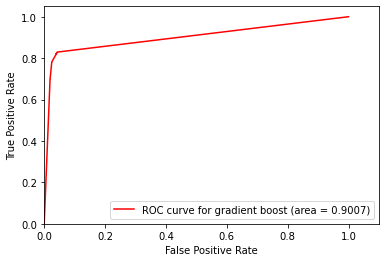

In [56]:
plt.plot(fpr_stackModel, tpr_stackModel, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_stackModel)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [57]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_stackModel)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.9007266870020035


<p><u>Comment</u></p>
<p>We see that the stacked model performs worse than the other 2 base models (Histogram gradient boost AUC: 0.96, bagging AUC: 0.94). One reasoning is that the stacked model requires more models, with some models producing high predictions to offset the low errors form other models. This will lead to a convergence effect, such that an ensemble of models will eventually outperform individual base models</p>

### Q2

In [58]:
f = open('16zpallagi.csv', 'r')
f.readline()
count = {}
for l in f.readlines():
    s = l.split(',')
    if s[2] == '0':
        count[s[1], int(s[3])] = int(s[4])
    else:
        count['%05d' % int(s[2]), int(s[3])] = int(s[4])
agg_count = {}
for k, v in count.items():
    if k[0][:3] not in agg_count:
        agg_count[k[0][:3]] = [0] * 7
    agg_count[k[0][:3]][k[1]] += v
f.close()

In [59]:
# Assume incomes bracketed are [12500, 37500, 62500, 87500, 150000, 400000]
# 1 = $1 under $25,000
# 2 = $25,000 under $50,000
# 3 = $50,000 under $75,000
# 4 = $75,000 under $100,000
# 5 = $100,000 under $200,000
# 6 = $200,000 or more

bracket_income = [0, 12500, 37500, 62500, 87500, 150000, 400000]
estimated_zip_income = {}
for k, v in agg_count.items():
    sumn, sumd = 0, 0
    for i in range(1, 7):
        sumn += bracket_income[i] * v[i]
        sumd += v[i]
    estimated_zip_income[k] = sumn / sumd

In [60]:
approved.insert(4, 'estimated_income', approved[['zip3', 'state']].apply(lambda x: estimated_zip_income[x[0]] if x[0] in estimated_zip_income else estimated_zip_income[x[1]] if x[1] in estimated_zip_income else 0, axis = 1))
rejected.insert(4, 'estimated_income', rejected[['zip3', 'state']].apply(lambda x: estimated_zip_income[x[0]] if x[0] in estimated_zip_income else estimated_zip_income[x[1]] if x[1] in estimated_zip_income else 0, axis = 1))
data_pos = approved.drop(['zip3', 'state'], axis = 1).values
data_neg = rejected.drop(['zip3', 'state'], axis = 1).values

In [61]:
data = np.vstack((data_pos, data_neg))
x_train, x_test, y_train, y_test = model_selection.train_test_split(data[:,:-1], data[:,-1].astype(int), test_size = 0.5, random_state = 2020)
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

Histogram based gradient boosting:

In [62]:
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
             param_grid={'l2_regularization': [0.01, 0.02, 0.03, 0.04]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [63]:
grid.best_params_

{'l2_regularization': 0.04}

In [64]:
hgbc_cla = HistGradientBoostingClassifier(l2_regularization = 0.04)

hgbc_cla.fit(x_train, y_train)

hgbc_y_pred = hgbc_cla.predict(x_test)

In [65]:
hgbc_cfm = metrics.confusion_matrix(y_test, hgbc_y_pred)
hgbc_cfm

array([[687710,  14385],
       [ 13876,  38047]], dtype=int64)

In [66]:
hgbc_tn, hgbc_fp, hgbc_fn, hgbc_tp = hgbc_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_hgbc = hgbc_tp / (hgbc_tp + hgbc_fp)
recall_hgbc = hgbc_tp/ (hgbc_tp + hgbc_fn)

print('True positive: ' + str(hgbc_tp))
print('False positive: ' + str(hgbc_fp))
print('True negative: ' + str(hgbc_tn))
print('False negative: ' + str(hgbc_fn))

print('precision: ' + str(precision_hgbc))
print('Recall: ' + str(recall_hgbc))

True positive: 38047
False positive: 14385
True negative: 687710
False negative: 13876
precision: 0.7256446444919133
Recall: 0.732758122604626


In [67]:
fhalf_hgbc = metrics.fbeta_score(y_test, hgbc_y_pred, beta = 0.5)
print('The f0.5 xgboost score is: ' + str(fhalf_hgbc))

The f0.5 xgboost score is: 0.7270562696110469


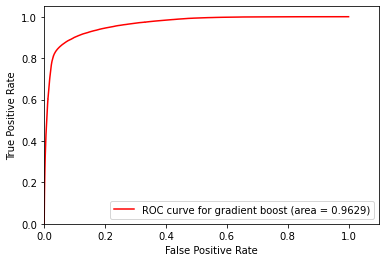

In [68]:
yProb_hgbc = hgbc_cla.predict_proba(x_test)
yProb_hgbc
# fpr = false +ve rates; tpr = true +ve rates
fpr_hgbc, tpr_hgbc, _ = metrics.roc_curve(y_test, yProb_hgbc[:,1])
auc_roc_hgbc = metrics.auc(fpr_hgbc, tpr_hgbc)

plt.plot(fpr_hgbc, tpr_hgbc, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_hgbc)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [69]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_hgbc)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.9628830655920753


<p>Bagging classifier:</p>

In [70]:
grid1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=BaggingClassifier(n_estimators=100, n_jobs=-1),
             param_grid={'max_samples': [1, 10, 100, 1000]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [71]:
grid1.best_params_

{'max_samples': 1000}

In [72]:
bag_cla = BaggingClassifier(max_samples = 10**3, n_estimators = 100)

bag_cla.fit(x_train, y_train)

bag_y_pred = bag_cla.predict(x_test)

In [73]:
bag_cfm = metrics.confusion_matrix(y_test, bag_y_pred)
bag_cfm

array([[685106,  16989],
       [ 12823,  39100]], dtype=int64)

In [74]:
bag_tn, bag_fp, bag_fn, bag_tp = bag_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_bag = bag_tp / (bag_tp + bag_fp)
recall_bag = bag_tp/ (bag_tp + bag_fn)

print('True positive: ' + str(bag_tp))
print('False positive: ' + str(bag_fp))
print('True negative: ' + str(bag_tn))
print('False negative: ' + str(bag_fn))

print('precision: ' + str(precision_bag))
print('Recall: ' + str(recall_bag))

True positive: 39100
False positive: 16989
True negative: 685106
False negative: 12823
precision: 0.6971063844960688
Recall: 0.753038152649115


In [87]:
fhalf_bag = metrics.fbeta_score(y_test, bag_y_pred, beta = 0.5)
print('The f0.5 xgboost score is: ' + str(fhalf_bag))

The f0.5 xgboost score is: 0.7076180238092653


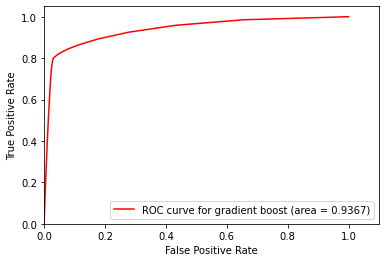

In [76]:
yProb_bag = bag_cla.predict_proba(x_test)
yProb_bag
# fpr = false +ve rates; tpr = true +ve rates
fpr_bag, tpr_bag, _ = metrics.roc_curve(y_test, yProb_bag[:,1])
auc_roc_bag = metrics.auc(fpr_bag, tpr_bag)

plt.plot(fpr_bag, tpr_bag, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_bag)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [77]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_bag)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.9367385102299375


### Model Stacking

In [78]:
params = {'hgbc__l2_regularization':[0.01 * i for i in range(1,5)],
          'bc__max_samples':[1, 10, 100, 1000],'bc__n_jobs':[-1],
         'final_estimator__ccp_alpha':[0.01 * i for i in range(1,5)]}

gridModel = model_selection.GridSearchCV(estimator = stackModel, param_grid = params, cv = 3, scoring = fhalf_scorer)

In [79]:
gridModel.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('hgbc',
                                                       HistGradientBoostingClassifier()),
                                                      ('bc',
                                                       BaggingClassifier(n_estimators=100))],
                                          final_estimator=RandomForestClassifier(max_depth=3,
                                                                                 n_jobs=-1)),
             param_grid={'bc__max_samples': [1, 10, 100, 1000],
                         'bc__n_jobs': [-1],
                         'final_estimator__ccp_alpha': [0.01, 0.02, 0.03, 0.04],
                         'hgbc__l2_regularization': [0.01, 0.02, 0.03, 0.04]},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [80]:
gridModel.best_params_

{'bc__max_samples': 1,
 'bc__n_jobs': -1,
 'final_estimator__ccp_alpha': 0.02,
 'hgbc__l2_regularization': 0.03}

In [81]:
stackModel_1 = StackingClassifier(estimators = estimators, 
                                final_estimator = RandomForestClassifier(n_estimators = 100, n_jobs = -1, 
                                                                         max_depth = 3, ccp_alpha = 0.02))
stackModel_1.fit(x_train, y_train)

stackModel_1_y_pred = stackModel_1.predict(x_test)

In [82]:
stackModel_cfm = metrics.confusion_matrix(y_test, stackModel_1_y_pred)
stackModel_cfm

array([[687862,  14233],
       [ 14444,  37479]], dtype=int64)

In [83]:
stackModel_tn, stackModel_fp, stackModel_fn, stackModel_tp = stackModel_cfm.ravel() # tn = true neg; fp = false pos; fn = false neg; tp = true pos

precision_stackModel = stackModel_tp / (stackModel_tp + stackModel_fp)
recall_stackModel = stackModel_tp/ (stackModel_tp + stackModel_fn)

print('True positive: ' + str(stackModel_tp))
print('False positive: ' + str(stackModel_fp))
print('True negative: ' + str(stackModel_tn))
print('False negative: ' + str(stackModel_fn))

print('precision: ' + str(precision_stackModel))
print('Recall: ' + str(recall_stackModel))

True positive: 37479
False positive: 14233
True negative: 687862
False negative: 14444
precision: 0.7247640779702971
Recall: 0.7218188471390328


In [84]:
fhalf_stackModel = metrics.fbeta_score(y_test, stackModel_1_y_pred, beta = 2)
print('The f2 xgboost score is: ' + str(fhalf_stackModel))

The f2 xgboost score is: 0.7224059767775363


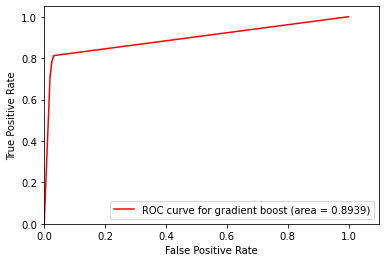

In [85]:
yProb_stackModel = stackModel_1.predict_proba(x_test)

# fpr = false +ve rates; tpr = true +ve rates
fpr_stackModel, tpr_stackModel, _ = metrics.roc_curve(y_test, yProb_stackModel[:,1])
auc_roc_stackModel = metrics.auc(fpr_stackModel, tpr_stackModel)

plt.plot(fpr_stackModel, tpr_stackModel, c = 'r', label = 'ROC curve for gradient boost (area = %0.4f)' % auc_roc_stackModel)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [86]:
print('The Area Under the Receiver Operating Characteristic Curve (AUC) is:', auc_roc_stackModel)

The Area Under the Receiver Operating Characteristic Curve (AUC) is: 0.8939126521331339


<p><b><u>Comment</u></b></p>
<p>summarised data:</p>
<p><u>No external data</u></p>
Boosting (Histogram based gradient boost):
<ol>
    <li>precision: 0.720114544535739</li>
    <li>Recall: 0.7410010977794041</li>
    <li>(AUC) is: 0.9621156155275242</li>
</ol>
Bagging (bagging classifier):
<ol>
    <li>precision: 0.7020792722547109</li>
    <li>Recall: 0.7491477765152245</li>
    <li>(AUC) is: 0.9433906282659188</li>
</ol>

Stacked Model (Final estimator: Random forest):

<ol>
    <li>precision: 0.7272635976540532</li>
    <li>Recall: 0.6973595516437802</li>
    <li>(AUC) is: 0.9007266870020035</li>
</ol>
<p><u>With external data:</u></p>
    
Boosting (Histogram based gradient boost):
<ol>
    <li>precision: 0.7256446444919133</li>
    <li>Recall: 0.732758122604626</li>
    <li>(AUC) is: 0.9628830655920753</li>
</ol>
    
Bagging (bagging classifier):
<ol>
    <li>precision: 0.6971063844960688</li>
    <li>Recall: 0.753038152649115</li>
    <li>(AUC) is: 0.9367385102299375</li>
</ol>
    
Stacked Model (Final estimator: Random forest):
<ol>
    <li>precision: 0.7247640779702971</li>
    <li>Recall: 0.7218188471390328</li>
    <li>(AUC) is: 0.8939126521331339</li>
</ol>

<p><u>Reasoning for the lack of starked improvement with external data:</u></p>
<p>The models chosen for both stacking and bagging were already able to classify well in the absence of external data, hence even with external data, there is no remarkable improvements.</p>
<p>The lack of performance in stacked model could also be attributed to the need to limit the depth of the forest, due to computational time needed. The max depth was set to 3 and it already took 2.5~3 hours. I can foresee that increasing the number of trees up to an optimal depth, can improve classification performance. However I would require higher computational powered machine. Besides, the high performance of both base models in the stacked model contributed to similar AUC values with/without external data (AUC without external:0.900726 ; AUC with external:0.893912) </p>